<a href="https://colab.research.google.com/github/yezarniko/PharmacyASR/blob/main/whisperFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!conda create  -n whisper python=3.11.13

In [ ]:
!python --version

Python 3.11.13


In [ ]:
import sys
sys.version

'3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]'

In [ ]:
!pip install transformers==4.50.3 jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 100.5 MB/s eta 0:00:00


In [ ]:
import transformers
transformers.__version__

'4.50.3'

In [ ]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import evaluate

In [ ]:
!pip install accelerate>=0.26.0 pandas matplotlib h5py librosa

In [ ]:
# !pip install -U openai-whisper

In [ ]:
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration, WhisperProcessor
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import pandas as pd
import os
import librosa
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union


## ASR Pipeline
The ASR pipeline can be de-composed into three components:

* A feature extractor which pre-processes the raw audio-inputs
* The model which performs the sequence-to-sequence mapping
* A tokenizer which post-processes the model outputs to text format

In Transformers, whisper model has an associated feature extractor and tokenizer
* WhisperFeatureExtractor
* WhisperTokenizer respectively.


In [ ]:
model_name = "openai/whisper-base.en"

## Load WhisperFeatureExtractor
The Whisper feature extractor performs two operations. It first pads/truncates a batch of audio samples such that all samples have an input length of 30s. Samples shorter than 30s are padded to 30s by appending zeros to the end of the sequence (zeros in an audio signal corresponding to no signal or silence). Samples longer than 30s are truncated to 30s. The second operation that the Whisper feature extractor performs is converting the padded audio arrays to log-Mel spectrograms. These spectrograms are a visual representation of the frequencies of a signal. Whisper feature extractor performs both the padding and spectrogram conversion.

In [ ]:
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name)
feature_extractor

WhisperFeatureExtractor {
  "chunk_length": 30,
  "dither": 0.0,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

## Load WhisperTokenizer
The Whisper model outputs text tokens that indicate the index of the predicted text among the dictionary of vocabulary items. The tokenizer maps a sequence of text tokens to the actual text string (e.g. [1169, 3797, 3332] -> "the cat sat").

Traditionally, when using encoder-only models for ASR, we decode using Connectionist Temporal Classification (CTC). Here we are required to train a CTC tokenizer for each dataset we use. One of the advantages of using an encoder-decoder architecture is that we can directly leverage the tokenizer from the pre-trained model.

The Whisper tokenizer is pre-trained on the transcriptions for the 96 pre-training languages. Consequently, it has an extensive byte-pair that is appropriate for almost all multilingual ASR applications. We can load the tokenizer and use it for fine-tuning without any further modifications.

We simply have to specify the target language and the task. These arguments inform the tokenizer to prefix the language and task tokens to the start of encoded label sequences:

In [ ]:
tokenizer = WhisperTokenizer.from_pretrained(model_name, task="transcribe", language="en")
processor = WhisperProcessor.from_pretrained(model_name, language="en", task="transcribe")

# tokenizer

In [ ]:
# Verify Tokenizer

input_str = "These arguments inform the tokenizer to prefix the language and task tokens to the start of encoded label sequences"
tokens = tokenizer(input_str).input_ids
text_tokens = [t.replace('Ġ', '_') for t in tokenizer.convert_ids_to_tokens(tokens)]


decoded_with_special = tokenizer.decode(tokens, skip_special_tokens=False)
decoded_str = tokenizer.decode(tokens, skip_special_tokens=True)

print("Input String: ", input_str)

print("\nTokens Vector: ")
print(pd.DataFrame(tokens))

print("\nDecoded: ", decoded_with_special)

pd.DataFrame(tokens, text_tokens)

Input String:  These arguments inform the tokenizer to prefix the language and task tokens to the start of encoded label sequences

Tokens Vector: 
        0
0   50257
1   50258
2   50358
3   50362
4    4711
5    7159
6    4175
7     262
8   11241
9    7509
10    284
11  21231
12    262
13   3303
14    290
15   4876
16  16326
17    284
18    262
19    923
20    286
21  30240
22   6167
23  16311
24  50256

Decoded:  <|startoftranscript|><|en|><|transcribe|><|notimestamps|>These arguments inform the tokenizer to prefix the language and task tokens to the start of encoded label sequences<|endoftext|>


,0
<|startoftranscript|>,50257
<|en|>,50258
<|transcribe|>,50358
<|notimestamps|>,50362
These,4711
_arguments,7159
_inform,4175
_the,262
_token,11241
izer,7509


## Preparing Data



In [ ]:
!wget https://huggingface.co/datasets/yezarniko/medicines-asr/resolve/main/medicines_asr_dataset_v2.h5.tar.gz

In [ ]:
!tar -xvzf medicines_asr_dataset_v2.h5.tar.gz

medicines_whisper_en_dataset_v2.h5


In [ ]:
audios = []
h5filename = "medicines_whisper_en_dataset_v2.h5"

with h5py.File(h5filename, "r") as f:
    samples = f["audio/samples"][:]
    sampling_rates = f["audio/sampling_rate"][:]
    sentences = f["sentence"][:]

for sample, sr, txt in zip(samples, sampling_rates, sentences):
    audio = {}
    audio["sample"] = sample
    audio["sampling_rate"] = sr
    audio["sentence"] = txt.decode('utf-8')

    audios.append(audio)

In [ ]:
# Compute Features and token vectors
audio_dataset = []

for audio in audios:

    a = {}

    # compute log-Mel
    a["input_features"] = feature_extractor(audio["sample"] , sampling_rate=audio["sampling_rate"]).input_features[0]

    # tokenize text
    a["labels"] = tokenizer(audio["sentence"]).input_ids

    audio_dataset.append(a)

audio_dataset = np.array(audio_dataset)
audio_dataset[0]
# audios

Text Token Vector:
                            0
<|startoftranscript|>  50257
<|en|>                 50258
<|transcribe|>         50358
<|notimestamps|>       50362
Par                    10044
acet                   23253
am                       321
ol                       349
<|endoftext|>          50256


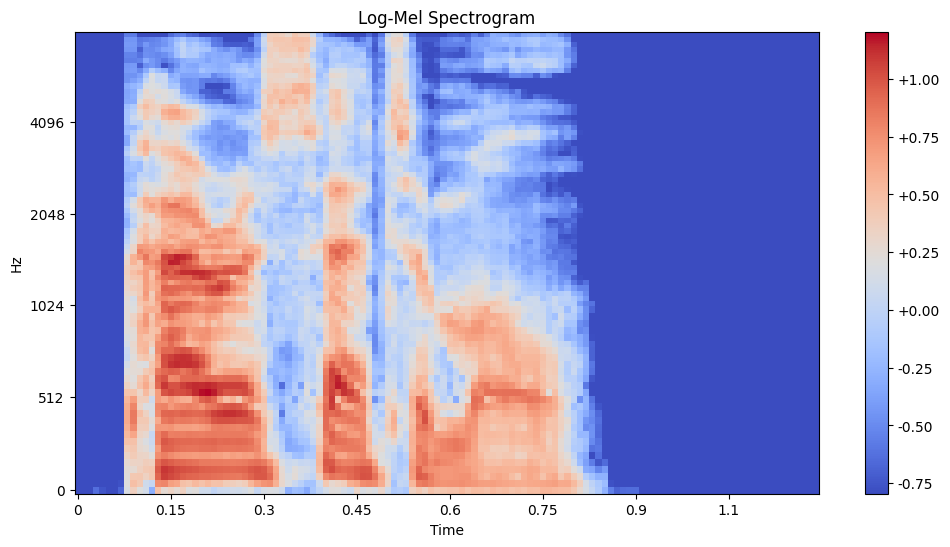

In [ ]:
# Sample 0's token vector
token_vector_0 = tokenizer(audios[0]["sentence"]).input_ids
print("Text Token Vector:\n", pd.DataFrame(token_vector_0, tokenizer.convert_ids_to_tokens(token_vector_0)))


# Sample 0's mel spectrum
features_0 = feature_extractor(audios[0]["sample"], sampling_rate=audios[0]["sampling_rate"]).input_features[0]

sr = 16000 # sampling rate of whisper 16kHz
hop_length = 160;
crop_second = 1.2;
end_frame = int(crop_second * sr / hop_length)
mel_np = features_0[:, :end_frame]

plt.figure(figsize=(12, 6))
librosa.display.specshow(
    mel_np,
    x_axis="time",
    y_axis="mel",
    sr=sr,
    hop_length=hop_length,
)
plt.title("Log-Mel Spectrogram")
plt.colorbar(format="%+2.2f")
plt.show()

## Training and Evaluation

#### Training pipeline

* Load a pre-trained checkpoint: load a pre-trained checkpoint and configure it correctly for training.

* Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model.

* Evaluation metrics: during evaluation, we want to evaluate the model using the word error rate (WER) metric. We need to define a compute_metrics function that handles this computation.

* Define the training arguments: these will be used by the Trainer in constructing the training schedule.

## Load a Pre-Trained Checkpoint

In [ ]:
model = WhisperForConditionalGeneration.from_pretrained(model_name)
model.generation_config.forced_decoder_ids = None
model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          

## Define a Data Collator

The data collator for a sequence-to-sequence speech model is unique in the sense that it treats the input_features and labels independently: the input_features must be handled by the feature extractor and the labels by the tokenizer.

The input_features are already padded to 30s and converted to a log-Mel spectrogram of fixed dimension, so all we have to do is convert them to batched PyTorch tensors. We do this using the feature extractor's `.pad` method with `return_tensors=pt`. Note that no additional padding is applied here since the inputs are of fixed dimension, the `input_features` are simply converted to PyTorch tensors.

On the other hand, the labels are un-padded. We first pad the sequences to the maximum length in the batch using the tokenizer's `.pad` method. The padding tokens are then replaced by `-100` so that these tokens are not taken into account when computing the loss. We then cut the start of transcript token from the beginning of the label sequence as we append it later during training.

We can leverage the WhisperProcessor we defined earlier to perform both the feature extractor and the tokenizer operations:



In [ ]:

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)



## Evaluation Metrics

We'll use the Word Error Rate (WER) metric, the 'de-facto' metric for assessing ASR systems./



In [ ]:
metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    if isinstance(pred_ids, tuple):
        pred_ids = pred_ids[0]

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

## Define the Training Arguments

* `output_dir`: local directory in which to save the model weights.
* `generation_max_length`: maximum number of tokens to autoregressively generate during evaluation.
* `save_steps`: during training, intermediate checkpoints will be saved.
* `eval_steps`: during training, evaluation of intermediate checkpoints will be performed every `eval_steps` training steps.
* `report_to`: where to save training logs. Supported platforms are "azure_ml", "comet_ml", "mlflow", "neptune", "tensorboard" and "wandb". Pick your favourite or leave as "tensorboard" to log to the Hub.



In [ ]:
output_dir = "./pharmacy-whisper-base-en"

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=5000,
    gradient_checkpointing=True,
    fp16=True,
    save_total_limit=2,
    remove_unused_columns=False,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=audio_dataset[0:5],
    eval_dataset=audio_dataset[5:],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=processor,
)

In [ ]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
1000,0.000100,0.000121,0.000000
2000,0.000000,0.000037,0.000000
3000,0.000000,0.000019,0.000000
4000,0.000000,0.000014,0.000000
5000,0.000000,0.000011,0.000000


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361]}. You are seeing this warning because you've set gener

TrainOutput(global_step=5000, training_loss=0.1641428264346061, metrics={'train_runtime': 1123.4315, 'train_samples_per_second': 71.21, 'train_steps_per_second': 4.451, 'total_flos': 1.621499904e+18, 'train_loss': 0.1641428264346061, 'epoch': 5000.0})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
kwargs = {
    "dataset_tags": "yezarniko/medicines-asr",
    "dataset": "Medicines ASR Dataset",
    "dataset_args": "config: en, split: test",
    "language": "en",
    "model_name": "Pharmacy ASR Whisper Base Model",
    "finetuned_from": "openai/whisper-base.en",
    "tasks": "automatic-speech-recognition",
}
trainer.push_to_hub(**kwargs)

Uploading...:   0%|          | 0.00/290M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yezarniko/whisper-pharmacyASR-base-en/commit/9edc3a8223327e566f77b955eff90638020e762e', commit_message='End of training', commit_description='', oid='9edc3a8223327e566f77b955eff90638020e762e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yezarniko/whisper-pharmacyASR-base-en', endpoint='https://huggingface.co', repo_type='model', repo_id='yezarniko/whisper-pharmacyASR-base-en'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="yezarniko/whisper-pharmacyASR-base-en")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text


Device set to use cuda:0


In [ ]:
# 1. Load processor & model
model = WhisperForConditionalGeneration.from_pretrained("yezarniko/whisper-pharmacyASR-base-en")
processor = WhisperProcessor.from_pretrained("yezarniko/whisper-pharmacyASR-base-en")

In [ ]:
# 2. Load audio
audio_path = "/content/paracetamol.wav"     # change path
audio, sr = librosa.load(audio_path, sr=16000)  # Whisper expects 16 kHz

In [ ]:
 # 3. Preprocess
inputs = processor(audio, sampling_rate=sr, return_tensors="pt")




In [ ]:
# 3. Generate transcription
with torch.no_grad():
    predicted_ids = model.generate(inputs["input_features"])



`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361], 'begin_suppress_tokens': [220, 50256]}. If this is not desired, please set these values explicitly.
A custom logits processor of type <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> has been passed to `.generate()`, but it was also created in `.generate()`, given its parameterization. The custom <class 'transformers.generation.logits_process.

In [ ]:
# 4. Decode the output
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
print("\nTRANSCRIPTION:\n", transcription)



TRANSCRIPTION:
  Paracetamol
